*Antonio Coín Castro   
INE*


# Práctica 2: evaluación

*Nota: las referencias consultadas se listan al final del documento.*

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import aux

%reload_ext autoreload
%autoreload 2

np.random.seed(2021)

## Evaluación offline

Utilizando el conjunto de datos introducidos por los estudiantes, suponiendo que los documentos no juzgados son todos irrelevantes (i.e. pooling profundidad 10), calcular para cada buscador:

- Precisión, Recall y Media Armónica.
- Mean Average Precision (MAP).
- Mean Reciprocal Rank (MRR).
- nDCG.
- Expected Reciprocal Rank (ERR) y Rank-Biased Precision (RBP, con p a elegir).

Realizar el cálculo por cada consulta, así como el promedio por buscador.

*Nota: todos los resultados que se muestran a continuación **coinciden con los que proporcionan las utilidades [trec_eval](https://github.com/usnistgov/trec_eval) ó [ndeval](https://github.com/trec-web/trec-web-2014)** al ejecutarla sobre los datos que hemos usado.*

### Lectura de datos

Hemos puesto el id de la consulta 30 a 28 para que sean todos consecutivos, ya que no existen la consulta 28 ni 29. 

Además, hemos eliminado todas las entradas de los archivos con errores de formato, considerando que los documentos correspondientes no eran relevantes. Es por esto que en algunas métricas realmente no estaremos haciendo el cálculo $@10$ exactamente para todas las consultas, pues puede que en algunas de ellas haya menos de 10 documentos devueltos por buscador.

In [2]:
# Load data

rels_engine = pd.read_csv(
    "data/rels_engine.csv",
    usecols=[0, 2, 3, 5],
    header=0,
    names=["id", "url", "rank", "engine"]
)

qrels = pd.read_csv(
    "data/qrels.csv",
    usecols=[0, 2, 3],
    header=0,
    names=["id", "url", "relevance"]
)

# Sort dataframes

rels_engine = rels_engine.sort_values(
    by=["id", "engine", "rank"]
)

qrels = qrels.sort_values(by=["id", "relevance"])

In [3]:
# Cross join of tables
df = rels_engine.merge(qrels, on=['id', 'url'], how='outer')

# Sort dataframe
df = df.sort_values(by=["id", "engine", "rank"])

# Sneak peek at dataframe
df.head()

,id,url,rank,engine,relevance
0,0,http://en.wikipedia.org/wiki/Information_retri...,1,bing,0
1,0,http://en.wikipedia.org/wiki/Information_theory,2,bing,1
2,0,http://nlp.stanford.edu/IR-book/pdf/irbookonli...,3,bing,1
3,0,http://www.britannica.com/topic/retrieval,4,bing,0
4,0,http://nlp.stanford.edu/IR-book/information-re...,5,bing,0


In [4]:
# Save useful information
engines = df['engine'].unique()
N = len(df['id'].unique())
M = len(engines)
AT = 10  # metrics @10

### Precisión (P), Recall (R) y media armónica (F)

Calculamos estas métricas para cada consulta y cada buscador, y luego hacemos estadísticas globales por buscadores. Las fórmulas utilizadas son:

$$
P_q^{(s)} = \frac{|Ret_q^{(s)} \cap Rel_q^{(s)}|}{|Ret_q^{(s)}|}, \quad R_q^{(s)} = \frac{|Ret_q^{(s)} \cap Rel_q^{(s)}|}{|Rel_q|}, \quad F_q^{(s)} = \frac{2P_q^{(s)}R_q^{(s)}}{P_q^{(s)}+R_q^{(s)}},
$$

donde:

- $Ret_q^{(s)}$ es el conjunto de documentos devueltos por el buscador $s$ para la consulta $q$, que en nuestro caso estamos considerando que tiene 10 elementos.
- $Rel_q^{(s)}$ es el conjunto de documentos relevantes para la consulta $q$ en el buscador $s$.
- $Rel_q$ es el conjunto completo de documentos relevantes para la consulta $q$ (que suponemos que es únicamente la unión de los documentos relevantes devueltos por todos los buscadores para esa consulta).

Además, si en algún caso tanto la Precisión como el Recall valen 0, establecemos que la correspondiente Media Armónica también vale 0. Notamos que como para cada buscador solo consideramos los 10 primeros documentos, realmente estamos calculando todas las métricas $@10$.

In [5]:
P = np.zeros((N, M))
R = np.zeros((N, M))
F = np.zeros((N, M))

for i in range(N):
    total_relevant_idx = sum(
        (qrels['relevance'] > 0) & (qrels['id'] == i)
    )
    df_idx = df[df['id'] == i]

    for j in range(M):
        relevant_eng = sum(
            (df_idx['engine'] == engines[j])
            & (df_idx['relevance'] > 0)
        )

        # Precision
        P[i, j] = relevant_eng/AT

        # Recall
        R[i, j] = relevant_eng/total_relevant_idx

        # Harmonic mean
        F[i, j] = 2*P[i, j]*R[i, j] / \
            (P[i, j] + R[i, j]) if relevant_eng > 0 else 0.0

metrics = {
    'Precisión': P,
    'Recall': R,
    'Media armónica': F
}

Enseñamos las estadísticas de un par de consultas al azar.

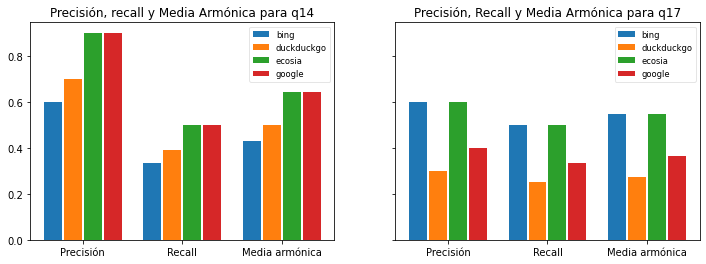

In [6]:
data, id_rand = aux.metrics_rand(2, N, metrics, engines)

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

axs[0].set_title(
    f"Precisión, Recall y Media Armónica para q{id_rand[0]}")
aux.bar_plot(
    axs[0],
    data[0],
    metrics.keys(),
    total_width=.8,
    single_width=.9)

axs[1].set_title(
    f"Precisión, Recall y Media Armónica para q{id_rand[1]}"
)
aux.bar_plot(
    axs[1],
    data[1],
    metrics.keys(),
    total_width=.8,
    single_width=.9)

plt.show()

Ahora enseñamos las estadísticas medias por buscador, así como la mediana, el mínimo y el máximo.

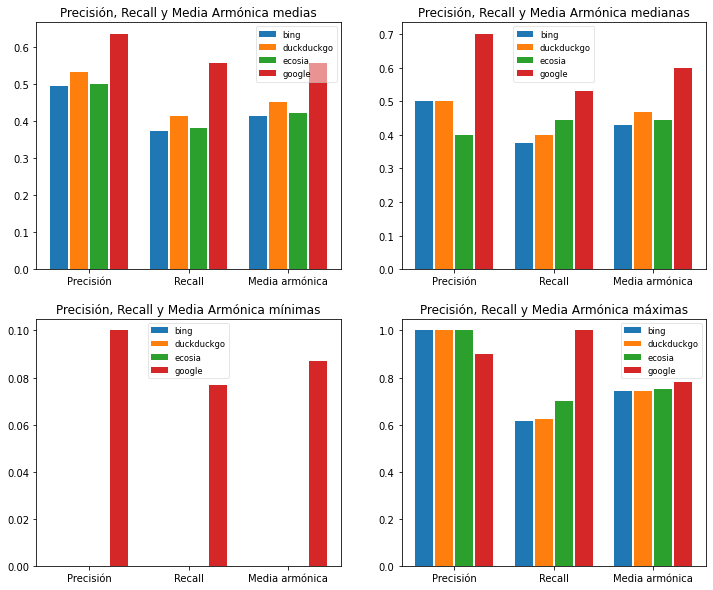

In [7]:
fns = {
    'medias': lambda x: np.mean(x, axis=0),
    'medianas': lambda x: np.median(x, axis=0),
    'mínimas': lambda x: np.min(x, axis=0),
    'máximas': lambda x: np.max(x, axis=0),
}

data = aux.metrics_summary(fns.values(), metrics, engines)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i in range(2):
    for j in range(2):
        axs[i, j].set_title(
            f"Precisión, Recall y Media Armónica {list(fns.keys())[2*i+j]}"
        )
        aux.bar_plot(axs[i, j], data[2*i+j], metrics.keys(),
                     total_width=.8, single_width=.9)

plt.show()

Los resultados medios obtenidos por buscador para Precisión, Recall y Media Armónica son los siguientes, donde hemos resaltado en negrita los mejores valores en cada caso:

| Buscador     | P          | R          | F          |
|:------------:|:----------:|:----------:|:----------:|
| bing         | 0.4931     | 0.3737     | 0.4142     |
| duckduckgo   | 0.5310     | 0.4123     | 0.4509     |
| ecosia       | 0.5000     | 0.3815     | 0.4213     |
| google       | **0.6345** | **0.5569** | **0.5555** |

Como vemos, para estas tres métricas Google es el vencedor, obteniendo una métrica media $F$ de 0.55, bastante por encima del siguiente buscador, que es DuckDuckGo. Google también se impone sobre el resto de buscadores en las métricas medias individuales $P$ y $R$. Por su parte, Bing es el que puntúa peor de todos en cuanto a la $F$ media.

Las métricas P y R se corresponden con las métricas `P_10` y `recall_10` de `trec_eval`, mientras que `F` es una simple transformación de estas.

### Mean Average Precision (mAP)

En primer lugar calculamos el Average Precision (AP) de cada buscador para cada consulta. Retomando la notación que introdujimos anteriormente, definimos esta métrica como:

$$
AP_q^{(s)}@10 = \frac{\sum_{k=1}^{10} P_q^{(s)}@k \cdot \mathcal I(d_{q,k}^{(s)} \text{ es relevante})}{|Rel_q|},
$$

donde $\mathcal I(\cdot)$ es la función indicadora, $d_{q,k}^{(s)}$ representa el documento $k$-ésimo devuelto por el buscador $s$ para la consulta $q$ (es decir, el documento en la posición $k$), y la métrica *precision-at-k* es:

$$
P_q^{(s)}@k = \frac{|\{d_{q,1}^{(s)}, \dots, d_{q,k}^{(s)}\} \cap Rel_q^{(s)}|}{k}. \quad 
$$

In [8]:
AP = np.zeros((N, M))

for i in range(N):
    total_relevant_idx = sum(
        (qrels['relevance'] > 0) & (qrels['id'] == i)
    )
    df_idx = df[df['id'] == i]

    for j in range(M):
        df_idx_eng = df_idx[df_idx['engine'] == engines[j]]

        relevants = 0
        sum_P = 0.0
        for k, dd in enumerate(df_idx_eng.iterrows()):
            if dd[1]['relevance'] > 0:
                relevants += 1
                sum_P += relevants/(k + 1)

        AP[i, j] = sum_P/total_relevant_idx

metrics = {'AP': AP}

Enseñamos el AP de un par de consultas al azar.

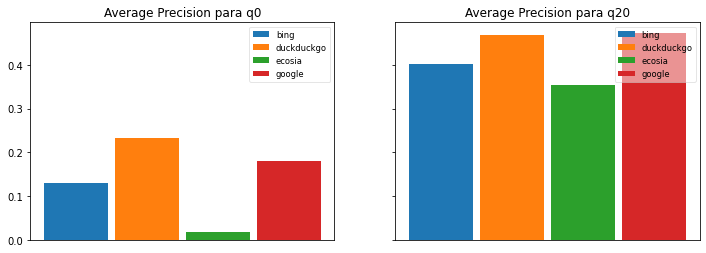

In [9]:
data, id_rand = aux.metrics_rand(2, N, metrics, engines)

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

axs[0].set_title(
    f"Average Precision para q{id_rand[0]}")
aux.bar_plot(
    axs[0],
    data[0],
    "",
    total_width=.8,
    single_width=.9)

axs[1].set_title(
    f"Average Precision para q{id_rand[1]}"
)
aux.bar_plot(
    axs[1],
    data[1],
    "",
    total_width=.8,
    single_width=.9)

plt.show()

Calculamos ahora el valor de Mean Average Precision (mAP), que no es más que el valor medio sobre todas las consultas de la métrica AP (para cada buscador):

$$
mAP^{(s)}@10 = \frac{\sum_{q=0}^{28} AP_q^{(s)}@10}{28}.
$$

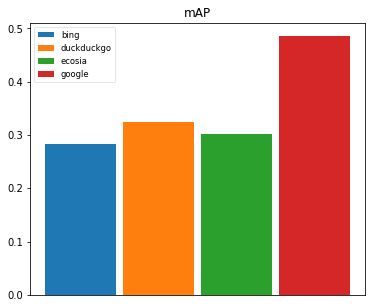

In [10]:
fns = {'mean': lambda x: np.mean(x, axis=0)}

data = aux.metrics_summary(fns.values(), metrics, engines)

fig, ax = plt.subplots(figsize=(6, 5))

ax.set_title("mAP")
aux.bar_plot(ax, data[0], "",
             total_width=.8, single_width=.9)

plt.show()

Los valores de mAP para cada buscador son:

| Buscador     | mAP        |
|:------------:|:----------:|
| bing         | 0.2821     | 
| duckduckgo   | 0.3237     | 
| ecosia       | 0.3022     |
| google       | **0.4857** |

De nuevo, Google se impone en esta métrica con bastante diferencia, y DuckDuckGo sigue en segundo puesto, mientras que Bing vuelve a ser el peor.

Esta métrica se corresponde con la métrica `map` de `trec_eval`.

### Mean Reciprocal Rank (MRR)

En primer lugar calculamos el Reciprocal Rank (RR) de cada buscador para cada consulta. Siguiendo la notación que hemos establecido, esta métrica se define como:

$$
RR_q^{(s)} = \frac{1}{\min\{k | \ d_{q,k}^{(s)} \text{ es relevante}\}}.
$$

Decidimos poner $RR_q^{(s)}=0$ cuando no haya ningún documento relevante entre los devueltos, de forma que no afecte después a la media.

In [11]:
RR = np.zeros((N, M))

for i in range(N):
    df_idx = df[df['id'] == i]

    for j in range(M):
        df_idx_eng = df_idx[df_idx['engine'] == engines[j]]

        if (df_idx_eng['relevance'] == 0).all():
            RR[i, j] = 0.0
        else:
            # True > False, so we do argmax
            RR[i, j] = 1./(np.argmax(df_idx_eng['relevance'] > 0) + 1)

metrics = {'RR': RR}

Enseñamos los valores de RR para dos consultas aleatorias.

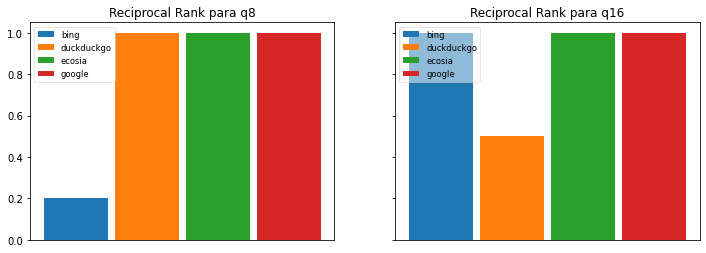

In [12]:
data, id_rand = aux.metrics_rand(2, N, metrics, engines)

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

axs[0].set_title(
    f"Reciprocal Rank para q{id_rand[0]}")
aux.bar_plot(
    axs[0],
    data[0],
    "",
    total_width=.8,
    single_width=.9)

axs[1].set_title(
    f"Reciprocal Rank para q{id_rand[1]}"
)
aux.bar_plot(
    axs[1],
    data[1],
    "",
    total_width=.8,
    single_width=.9)

plt.show()

Calculamos ahora los valores de la métrica mRR para cada buscador, que no es más que hacer la media de RR para todas las consultas consideradas:

$$
mRR^{(s)} = \frac{\sum_{q=0}^{28} RR_q^{(s)}}{28}.
$$

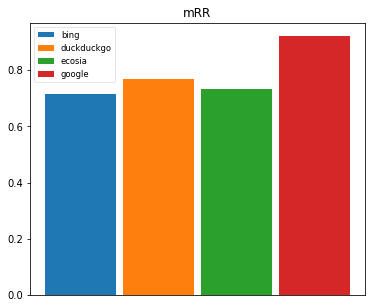

In [13]:
fns = {'mean': lambda x: np.mean(x, axis=0)}

data = aux.metrics_summary(fns.values(), metrics, engines)

fig, ax = plt.subplots(figsize=(6, 5))

ax.set_title("mRR")
aux.bar_plot(ax, data[0], "",
             total_width=.8, single_width=.9)

plt.show()

Los valores de mRR para cada buscador son:

| Buscador     | mRR        |
|:------------:|:----------:|
| bing         | 0.7138     | 
| duckduckgo   | 0.7701     | 
| ecosia       | 0.7337     |
| google       | **0.9224** |

Los resultados siguien en la misma tónica que anteriormente: Google supera al resto con diferencia, le sigue DuckDuckgo, luego Ecosia y finalmente Bing.

Esta métrica se corresponde con la métrica `recip_rank` de `trec_eval`.

### Normalized Discounted Cumulated Gain (nDCG)

La métrica nDCG se define como 

$$
nDCG_q^{(s)}=\frac{DCG_q^{(s)}}{IDCG_q^{(s)}}.
$$

Si $g\left(d_{q, k}^{(s)}\right)$ representa el grado de relevancia (en nuestro caso en $\{0, 1, 2\}$) del documento $k$-ésimo devuelto por el buscador $s$ para la consulta $q$, entonces

$$
DCG_q^{(s)} = \sum_{k=1}^{|Ret_q^{(s)}|} \frac{g\left(d_{q, k}^{(s)}\right)}{\log_2(k+1)},
$$

donde notamos que los documentos no relevantes no contribuyen al sumatorio. Por otro lado, la constante de normalización es el DCG ideal, que viene dado por

$$
IDCG_q^{(s)} = \max_{R\in Rel_q} DCG_q^{(s)}(R),
$$

que no es más que el mayor DCG que podríamos conseguir teniendo en cuenta el corpus completo de documentos relevantes para la consulta $q$. Gracias a esta normalización, el valor de $nDCG$ se encuentra en $[0,1]$ y es comparable para diferentes consultas.

En nuestro caso, como solo tenemos 10 documentos por cada consulta y buscador, lo que calculamos realmente es:

$$
nDCG_q^{(s)}@10 = \frac{DCG_q^{(s)}@10}{IDCG_q^{(s)}@10}.
$$

In [14]:
def DCG(df, lim=None):
    if lim is None:
        lim = df.shape[0]

    return np.sum(
        [df.iloc[k]['relevance']/(np.log2(k + 2))
         for k in range(min(lim, df.shape[0]))]
    )


nDCG = np.zeros((N, M))

for i in range(N):
    df_idx = df[df['id'] == i]
    df_idx_top_rel = qrels[qrels['id'] == i].sort_values(
        by=["relevance"], ascending=False
    )
    IDCG = DCG(df_idx_top_rel, lim=AT)

    for j in range(M):
        df_idx_eng = df_idx[df_idx['engine'] == engines[j]]

        nDCG[i, j] = DCG(df_idx_eng)/IDCG

metrics = {'nDCG': nDCG}

Mostramos el valor de nDCG para dos consultas al azar.

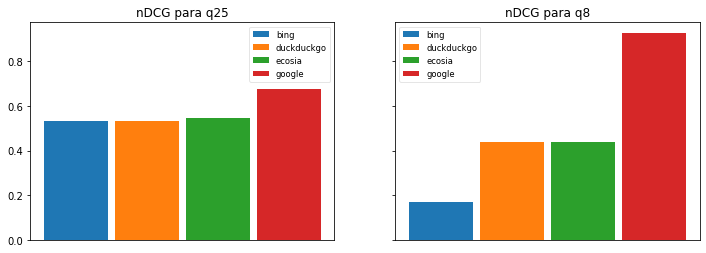

In [15]:
data, id_rand = aux.metrics_rand(2, N, metrics, engines)

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

axs[0].set_title(
    f"nDCG para q{id_rand[0]}"
)
aux.bar_plot(
    axs[0],
    data[0],
    "",
    total_width=.8,
    single_width=.9
)

axs[1].set_title(
    f"nDCG para q{id_rand[1]}"
)
aux.bar_plot(
    axs[1],
    data[1],
    "",
    total_width=.8,
    single_width=.9
)

plt.show()

Finalmente mostramos el valor medio de la métrica para cada buscador, promediando nDCG sobre todas las consultas.

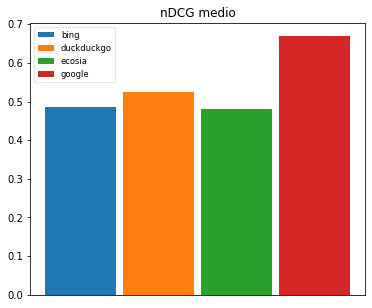

In [16]:
fns = {'mean': lambda x: np.mean(x, axis=0)}

data = aux.metrics_summary(fns.values(), metrics, engines)

fig, ax = plt.subplots(figsize=(6, 5))

ax.set_title("nDCG medio")
aux.bar_plot(ax, data[0], "",
             total_width=.8, single_width=.9)

plt.show()

Los valores medios de nDCG para cada buscador son:

| Buscador     | nDCG       |
|:------------:|:----------:|
| bing         | 0.4871     | 
| duckduckgo   | 0.5246     | 
| ecosia       | 0.4811     |
| google       | **0.6696** |

De nuevo se observa el mismo ranking que con el resto de métricas, con la excepción de que en este caso Bing supera a Ecosia por la mínima.

Esta métrica se corresponde con la métrica `ndcg_cut_10` de `trec_eval`.

### Expected Reciprocal Rank (ERR)

La métrica ERR se define como

$$
ERR_q^{(s)} = \sum_{k=1}^{|Ret_q^{(s)}|} \frac{1}{k} p\left(r\mid d_{q,k}^{(s)}\right) \prod_{j=1}^{k-1} \left(1-p\left(r\mid d_{q,j}^{(s)}\right)\right),
$$

donde $p(r\mid d)$ representa la probabilidad de quedar satisfecho con el documento $d$ (entendida como una función de utilidad). Esta probabilidad se puede modelar de varias maneras, siendo las dos principales:

- $p(r\mid d) = \displaystyle\frac{2^{g(d)} - 1}{2^{\max g}}$, donde $g$ es una función que modela el grado de relevancia de los documentos (en nuestro caso, $g(d)\in \{0, 1, 2\}$).

- $p(r\mid d) = \begin{cases} 1 & \text{si $d$ es relevante},\\ 0, & \text{en otro caso}.\end{cases}$

Nosotros consideramos principalmente la primera opción, aunque la herramienta `ndeval` implementa la segunda. Por tanto, calculamos también el valor de EER en ese caso, para comparar con el que devuelve la utilidad.

In [17]:
def p_rel_ndeval(relevance):
    """Relevance function from ndeval."""
    return 1 if relevance > 0 else 0


def p_rel(relevance):
    """Our relevance function."""
    return (2**relevance - 1) / 2**2


def compute_ERR(utility_func):

    ERR = np.zeros((N, M))

    for i in range(N):
        df_idx = df[df['id'] == i]

        for j in range(M):
            df_idx_eng = df_idx[df_idx['engine'] == engines[j]]
            num_ret = df_idx_eng.shape[0]

            p_rel_acum = 1.0
            ERR_aux = 0.0
            for k in range(num_ret):
                p_rel_curr = \
                    utility_func(df_idx_eng.iloc[k]['relevance']) 
                ERR_aux += p_rel_curr*p_rel_acum/(k+1)
                p_rel_acum *= 1 - p_rel_curr

            ERR[i, j] = np.sum(ERR_aux)
            
    return ERR


metrics = {
    'ERR': compute_ERR(p_rel),
    'EER_ndeval': compute_ERR(p_rel_ndeval)
}

Mostramos el valor de ERR para un par de consultas al azar, utilizando las dos funciones de utilidad mencionadas antes.

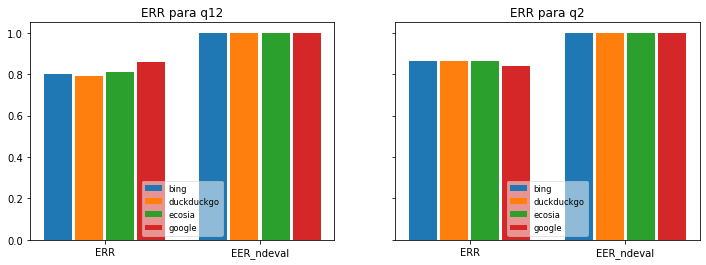

In [18]:
data, id_rand = aux.metrics_rand(2, N, metrics, engines)

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

axs[0].set_title(
    f"ERR para q{id_rand[0]}")
aux.bar_plot(
    axs[0],
    data[0],
    metrics.keys(),
    total_width=.8,
    single_width=.9)

axs[1].set_title(
    f"ERR para q{id_rand[1]}"
)
aux.bar_plot(
    axs[1],
    data[1],
    metrics.keys(),
    total_width=.8,
    single_width=.9)

plt.show()

Finalmente mostramos el valor medio de ERR para cada buscador, promediando sobre todas las consultas.

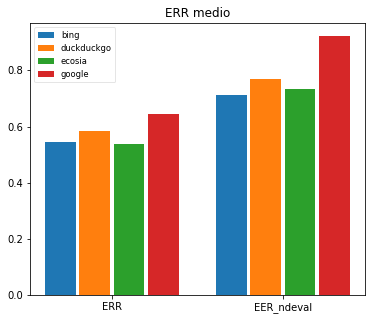

In [19]:
fns = {'mean': lambda x: np.mean(x, axis=0)}

data = aux.metrics_summary(fns.values(), metrics, engines)

fig, ax = plt.subplots(figsize=(6, 5))

ax.set_title("ERR medio")
aux.bar_plot(ax, data[0], metrics.keys(),
             total_width=.8, single_width=.9)

plt.show()

Los valores medios de ERR para cada buscador utilizando ambas funciones de utilidad son:

| Buscador     | ERR        | ERR_ndeval |
|:------------:|:----------:|:----------:|
| bing         | 0.5459     | 0.7138     | 
| duckduckgo   | 0.5843     | 0.7701     |
| ecosia       | 0.5368     | 0.7337     |
| google       | **0.6461** | **0.9224** |

Google encabeza esta métrica, seguido de DuckDuckGo, luego Bing, y esta vez el perdedor es Ecosia. Como vemos, obtenemos valores más grandes de la métrica en el caso de la segunda fución de utilidad, porque premiamos de igual manera los documentos relevantes, sea cual sea su grado de relevancia.

Los valores de la última columna se corresponden con la métrica `ERR-IA@10` de `ndeval` cuando establecemos `alpha=1`. 

### Rank-Biased Precision (RBP)

La métrica RBP surge de asumir como simplificación que la probabilidad de pasar al documento siguiente es constante en todas las posiciones: $p(\text{cont}\mid d)=p$. Teniendo esto en cuenta, se define como:

$$
RBP_q^{(s)}(p)= (1-p)\sum_{k=1}^{|Ret_q^{(s)}|} p^{k-1}g\left( d_{q,k}^{(s)}\right).
$$


Un último detalle es que, si queremos que el valor de la métrica esté normalizado en $[0,1]$, debemos dividir toda la expresión por el máximo valor de relevancia que podemos tener, que en nuestro caso es $\max g = 2$ (ver por ejemplo ${\color{blue}{[1]}}$). Entonces, la expresión final sería:

$$
RBP_q^{(s)}(p)= \frac{(1-p)}{\max g}\sum_{k=1}^{|Ret_q^{(s)}|} p^{k-1}g\left( d_{q,k}^{(s)}\right).
$$

Esto es así porque la constante de normalización $1-p$ está pensada originalmente para el caso de relevancia binaria. De hecho, como `ndeval` implementa por defecto esta opción, también consideramos alternativamente esta función de relevancia para hacer las cuentas (es decir, solo nos importa si un documento es relevante o no).

Para nuestras cuentas, tomamos por ejemplo $p=0.8$.

In [20]:
def p_rel_ndeval(relevance):
    """Relevance function from ndeval."""
    return 1 if relevance > 0 else 0


def p_rel(relevance):
    """Our relevance function: g(d)/(max g)."""
    return relevance/2.


def compute_RBP(p, rel_func):

    RBP = np.zeros((N, M))

    for i in range(N):
        df_idx = df[df['id'] == i]

        for j in range(M):
            df_idx_eng = df_idx[df_idx['engine'] == engines[j]]
            num_ret = df_idx_eng.shape[0]

            # Binary relevance
            RBP[i, j] = (1-p) * np.sum(
                [(p**k) * rel_func(df_idx_eng.iloc[k]['relevance'])
                for k in range(num_ret)])
            
    return RBP


metrics = {
    'RBP': compute_RBP(p=0.8, rel_func=p_rel),
    'RBP_ndeval': compute_RBP(p=0.8, rel_func=p_rel_ndeval)
}

Mostramos el valor de RBP para dos consultas aleatorias, utilizando las dos posibles funciones de relevancia.

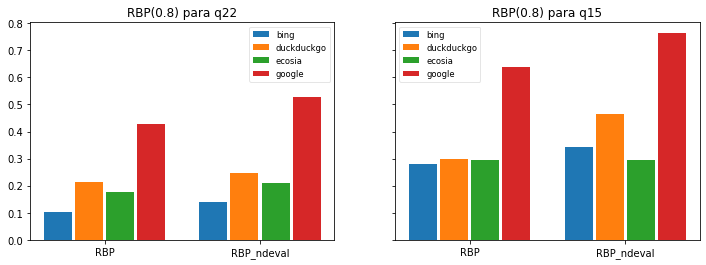

In [21]:
data, id_rand = aux.metrics_rand(2, N, metrics, engines)

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

axs[0].set_title(
    f"RBP(0.8) para q{id_rand[0]}")
aux.bar_plot(
    axs[0],
    data[0],
    metrics.keys(),
    total_width=.8,
    single_width=.9)

axs[1].set_title(
    f"RBP(0.8) para q{id_rand[1]}"
)
aux.bar_plot(
    axs[1],
    data[1],
    metrics.keys(),
    total_width=.8,
    single_width=.9)

plt.show()

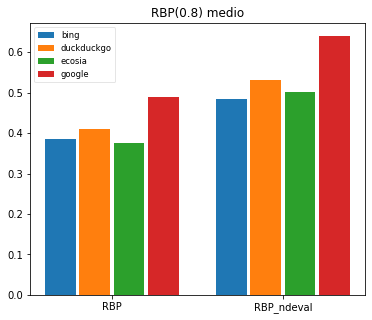

In [22]:
fns = {'mean': lambda x: np.mean(x, axis=0)}

data = aux.metrics_summary(fns.values(), metrics, engines)

fig, ax = plt.subplots(figsize=(6, 5))

ax.set_title("RBP(0.8) medio")
aux.bar_plot(ax, data[0], metrics.keys(),
             total_width=.8, single_width=.9)

plt.show()

Los valores medios de RBP para cada buscador utilizando las dos funciones de relevancia son:

| Buscador     | RBP        | RBP_ndeval |
|:------------:|:----------:|:----------:|
| bing         | 0.3853     | 0.4854     | 
| duckduckgo   | 0.4109     | 0.5312     |
| ecosia       | 0.3755     | 0.5006     |
| google       | **0.4894** | **0.6399** |

En ambos casos se mantiene más o menos el ranking que veníamos viendo hasta ahora.

Los valores de la última columna se corresponden con la métrica `NRBP` de `ndeval` cuando establecemos `alpha=0` y `beta=0.8`. 

### Resumen de métricas

Para concluir mostramos en la misma tabla todas las métricas consideradas.

| Buscador     | P          | R          | F          | mAP        | mRR        | nDCG       | ERR        | ERR_ndeval | RBP        | RBP_ndeval |
|:------------:|:----------:|:----------:|:----------:|:----------:|:----------:|:----------:|:----------:|:----------:|:----------:|:----------:|
| bing         | 0.4931     | 0.3737     | 0.4142     | 0.2821     | 0.7138     | 0.4871     | 0.5459     | 0.7138     | 0.3853     | 0.4854     |
| duckduckgo   | 0.5310     | 0.4123     | 0.4509     | 0.3237     | 0.7701     | 0.5246     | 0.5843     | 0.7701     | 0.4109     | 0.5312     |
| ecosia       | 0.5000     | 0.3815     | 0.4213     | 0.3022     | 0.7337     | 0.4811     | 0.5368     | 0.7337     | 0.3755     | 0.5006     |
| google       | **0.6345** | **0.5569** | **0.5555** | **0.4857** | **0.9224** | **0.6696** | **0.6461** | **0.9224** | **0.4894** | **0.6399** |



No hay duda de que Google es el claro vencedor, mientras que Bing parece ser el peor, seguido no muy de lejos por Ecosia. Por su parte, DuckDuckGo parece ser más competitivo pero no consigue acercarse a las métricas que obtiene Google.

## Evaluación online con clicks

Realizar una evaluación basada en clicks utilizando los logs obtenidos de la sesión de búsqueda realizada por los alumnos:

- [Log de clicks completo](http://ir.ii.uam.es/~alejandro/2020/ir/click-log.txt).
- [Log de clicks agregado](http://ir.ii.uam.es/~alejandro/2020/ir/click-count.txt).
- [Rankings devueltos por los buscadores para las consultas que han recibido](http://ir.ii.uam.es/~alejandro/2020/ir/rankings_mod.txt).

Calcular las siguientes métricas para los buscadores que aparecen en el log: 

- Clicks por consulta.
- Tasa de abandono.
- Max RR y Mean RR. 

Ignorar por el momento los clicks atribuidos a rankings intercalados `google+bing` (se propone más abajo como ejercicio opcional).

### Lectura de datos

In [23]:
# Load data

click_log = pd.read_csv(
    "http://ir.ii.uam.es/~alejandro/2020/ir/click-log.txt",
    usecols=[1, 2, 4],
    sep="\t",
    header=0,
    names=["engine", "id", "rank_clicked"]
)

click_count = pd.read_csv(
    "http://ir.ii.uam.es/~alejandro/2020/ir/click-count.txt",
    usecols=[1, 2, 3],
    sep="\t",
    header=0,
    names=["engine", "id", "count"]
)

# Sort dataframes

click_log = click_log.sort_values(
    by=["id", "engine", "rank_clicked"]
)

click_count = click_count.sort_values(
    by=["id", "engine", "count"]
)

# Drop google+bing

click_log = click_log[click_log.engine != 'google+bing']
click_count = click_count[click_count.engine != 'google+bing']

In [24]:
# Save useful information
engines = click_log['engine'].unique()
M = len(engines)

### Clicks por consulta

Simplemente miramos cuántos clicks hay por cada buscador para cada consulta, y hacemos la media por buscadores. Si $Q^{(s)}$ es el conjunto total de consultas (sesiones) para el buscador $q$, esta métrica se define como

$$
\operatorname{ClicksPerSession}^{(s)} = \frac{1}{|Q^{(s)}|} \sum_{q=1}^{|Q^{(s)}|} |Clk^{(s)}_q|,
$$

donde $Clk_q^{(s)}$ es el conjunto de documentos clickados para la consulta (sesión) $q$ en el buscador $s$. Esta métrica podemos calcularla teniendo en cuenta únicamente las consultas con algún click, o teniendo en cuenta todas las consultas (sufijo `_all` en los resultados que siguen).

In [39]:
data = click_count[click_count['count'] > 0].groupby(
['engine'], as_index=False)["count"].mean()

print("Clicks por consulta solo con las consultas con algún click:")
data

Clicks por consulta solo con las consultas con algún click:


,engine,count
0,ask,2.480000
1,bing,1.333333
2,duckduckgo,1.905405
3,google,2.253165


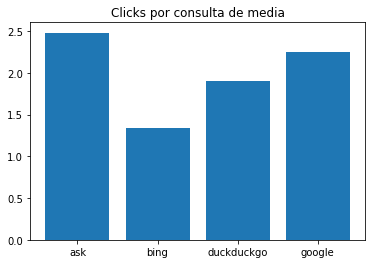

In [26]:
plt.bar(data["engine"], data["count"])
plt.title("Clicks por consulta de media")
plt.show()

In [40]:
data_all = click_count.groupby(
    ["engine"], as_index=False)["count"].mean()

print("Clicks por consulta con todas las consultas:")
data_all

Clicks por consulta con todas las consultas:


,engine,count
0,ask,1.550000
1,bing,0.041667
2,duckduckgo,1.468750
3,google,1.663551


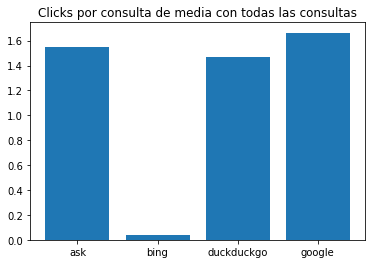

In [28]:
plt.bar(data_all["engine"], data_all["count"])
plt.title("Clicks por consulta de media con todas las consultas")
plt.show()

### Tasa de abandono

Se trata del ratio de sesiones que acaban sin ningún click sobre el total de sesiones para cada buscador:

$$
\operatorname{DropoutRate^{(s)}} = \frac{\left|\left\{q \in Q^{(s)}: \, Clk_q^{(s)}=\emptyset \right\}\right|}{|Q^{(s)}|}.
$$

In [29]:
df_abandon = click_count[click_count['count'] == 0]
count_abandon = df_abandon.groupby("engine", as_index=False)[
    'count'].count().to_numpy()
count_all = click_count.groupby("engine", as_index=False)[
    'count'].count().to_numpy()
count_abandon[:, 1] /= count_all[:, 1]
dropout = pd.DataFrame(
    count_abandon, columns=["engine", "dropout rate"])

print("Tasa de abandono:")
dropout

Tasa de abandono:


,engine,dropout rate
0,ask,0.375
1,bing,0.96875
2,duckduckgo,0.229167
3,google,0.261682


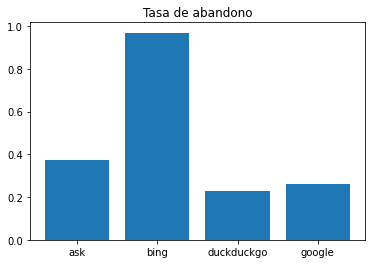

In [30]:
plt.bar(dropout["engine"], dropout["dropout rate"])
plt.title("Tasa de abandono")
plt.show()

## Mean RR and Max RR

Para calcular estas métricas atendemos a la definición dada en ${\color{blue}{[2]}}$. Concretamente, tenemos:

$$\operatorname{MeanRR}^{(s)}= \frac{1}{|Q^{(s)}|} \sum_{q=1}^{|Q^{(s)}|} \operatorname{SumRR}_q^{(s)},
$$

donde 
$$
\operatorname{SumRR}_q^{(s)} = \sum_{k=1}^{|Ret_q^{(s)}|} \frac{1}{k}\mathcal I\left(d_{q,k}^{(s)} \text{ ha sido clickado}\right).
$$

Notamos que podemos normalizar esta métrica y dividir en cada caso por el número de documentos clickados, haciendo efectivamente "la media de la media", obteniendo la versión normalizada:

$$
\operatorname{MeanRR}^{(s)}= \frac{1}{|Q^{(s)}|} \sum_{q=1}^{|Q^{(s)}|} \frac{1}{|Clk_q^{(s)}|}\sum_{k=1}^{|Ret_q^{(s)}|} \frac{1}{k}\mathcal I\left(d_{q,k}^{(s)} \text{ ha sido clickado}\right),
$$

Por otro lado, se define

$$
\operatorname{MaxRR}^{(s)}= \frac{1}{|Q^{(s)}|} \sum_{q=1}^{|Q^{(s)}|}\frac{1}{\operatorname{rank}_q^{(s)}},
$$

donde $\operatorname{rank}_q^{(s)}$ es la posición más alta en el ranking de entre los resultados clickados para la consulta $q$ en el buscador $s$.


Normalmente estas métricas se calculan únicamente teniendo en cuenta consultas con algún click. Sin embargo, damos también la opción de calcularla con todas las consultas disponibles, dando a la métrica el valor 0 en aquellas donde no haya habido ningún click (lo que indicamos con el sufijo `_all` en lo que sigue).

In [31]:
def compute_mean_max_RR(value_not_clicked=np.nan):
    Mean_RR = np.empty(M, dtype=object)
    Max_RR = np.empty(M, dtype=object)

    for i in range(M):
        df_engine = click_log[click_log['engine'] == engines[i]]
        Mean_RR[i] = []
        Max_RR[i] = []

        for qid in df_engine['id'].unique():
            df_idx_eng = \
                df_engine[df_engine['id'] == qid].dropna()

            if df_idx_eng.size > 0:
                Mean_RR[i].append(
                    (1./df_idx_eng['rank_clicked']).mean())
                Max_RR[i].append(
                    (1./df_idx_eng['rank_clicked']).max())
            else:
                Mean_RR[i].append(value_not_clicked)
                Max_RR[i].append(value_not_clicked)

    return Mean_RR, Max_RR


Mean_RR, Max_RR = compute_mean_max_RR(np.nan)
Mean_RR_all, Max_RR_all = compute_mean_max_RR(0.0)

metrics_meanRR = {
    'Mean_RR': Mean_RR,
    'Mean_RR_all': Mean_RR_all
}
metrics_maxRR = {
    'Max_RR': Max_RR,
    'Max_RR_all': Max_RR_all
}

Mostramos ahora los valores de Mean RR y Max RR para cada buscador.

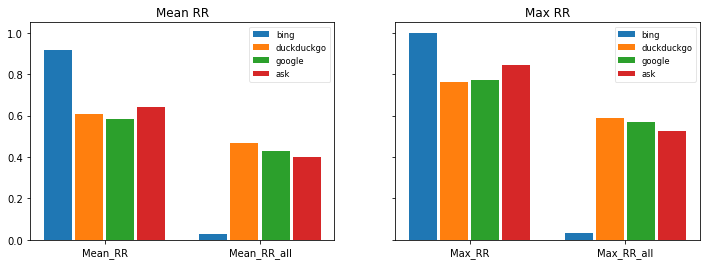

In [32]:
def mean_list(lst):
    mean_arr = np.zeros(len(lst))
    
    for i, x in enumerate(lst):
        mean_arr[i] = np.nanmean(x)
    
    return mean_arr


fns = {
    'mean': mean_list
}

data_meanRR = aux.metrics_summary(
    fns.values(), metrics_meanRR, engines)
data_maxRR = aux.metrics_summary(
    fns.values(), metrics_maxRR, engines)

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

axs[0].set_title(
    f"Mean RR")
aux.bar_plot(
    axs[0],
    data_meanRR[0],
    metrics_meanRR.keys(),
    total_width=.8,
    single_width=.9)

axs[1].set_title("Max RR")
aux.bar_plot(
    axs[1],
    data_maxRR[0],
    metrics_maxRR.keys(),
    total_width=.8,
    single_width=.9)

plt.show()

Los valores obtenidos para la métrica Mean RR son, según la estrategia seguida para valorar consultas sin clicks:

| Buscador     | Mean_RR    | Mean_RR_all |
|:------------:|:----------:|:-----------:|
| bing         | **0.9167** | 0.0287      | 
| duckduckgo   | 0.6095     | **0.4698**  |
| google       | 0.5844     | 0.4315      |
| ask          | 0.6395     | 0.3997      |

Los valores obtenidos para la métrica Max RR según la estrategia seguida para valorar consultas sin clicks son:

| Buscador     | Max_RR     | Max_RR_all |
|:------------:|:----------:|:----------:|
| bing         | **1.0000** | 0.0313     | 
| duckduckgo   | 0.7605     | **0.5862** |
| google       | 0.7711     | 0.5694     |
| ask          | 0.8423     | 0.5265     |

Como vemos, si ignoramos las consultas sin clicks el buscador Bing obtiene unos valores muy altos para las métricas, pero esto ocurre porque tiene muy pocas consultas con algún click. En general, podemos decir que DuckDuckGo es el vencedor, si hacemos caso a la métrica que considera todas las consultas, que quizás es más justa.

### Resumen de métricas

Mostramos a continuación una tabla resumen con todas las métricas:

| Buscador     | Mean_RR    | Mean_RR_all | Max_RR     | Max_RR_all | Tasa abandono | Clicks/consulta | Clicks/consulta_all |
|:------------:|:----------:|:-----------:|:----------:|:----------:|:----------:|:----------:|:---------:|
| bing         | **0.9167** | 0.0287      | **1.0000** | 0.0313     | 0.9688 | 0.0417 | 1.3333 |
| duckduckgo   | 0.6095     | **0.4698**  | 0.7605     | **0.5862** | **0.2292** | 1.4688 | 1.9054 |
| google       | 0.5844     | 0.4315      | 0.7711     | 0.5694     | 0.2617 | **1.6636** | 2.2532 |
| ask          | 0.6395     | 0.3997      | 0.8423     | 0.5265     | 0.3750 | 1.5500 | **2.4800** |

Como vemos, en la evaluación online ya no está tan claro que Google siga imponiéndose, ya que por ejemplo DuckDuckGo obtiene mejores resultados en la mayoría de métricas consideradas.

## Evaluación A/B (ejercicio opcional)

Realizar una evaluación A/B de Google vs. Bing utilizando los clicks sobre ránkings intercalados `google+bing` del ejercicio anterior, sabiendo que se ha utilizado el método balanceado. A criterio del propio estudiante, decidir el número de consultas a procesar en el ejercicio para dimensionar razonablemente el esfuerzo vs. provecho del estudiante.

### Lectura de datos

In [33]:
# Load data

click_log = pd.read_csv(
    "http://ir.ii.uam.es/~alejandro/2020/ir/click-log.txt",
    usecols=[1, 2, 4, 5],
    sep="\t",
    header=0,
    names=["engine", "id", "rank_clicked", "url"]
)

click_ranking = pd.read_csv(
    "http://ir.ii.uam.es/~alejandro/2020/ir/rankings_mod.txt",
    usecols=[0, 1, 2, 3],
    sep="\t",
    header=0,
    names=["id", "engine", "rank", "url"]
)

# Sort dataframes

click_log = click_log.sort_values(
    by=["id", "engine", "rank_clicked"]
)

click_ranking = click_ranking.sort_values(
    by=["id", "engine", "rank"]
)

# Drop duckduckgo and ask

click_log = click_log[
    (click_log.engine != 'ask') &
    (click_log.engine != 'duckduckgo')]

click_ranking = click_ranking[
    (click_ranking.engine != 'ask') &
    (click_ranking.engine != 'duckduckgo')]

En principio nos quedamos para la evaluación con todas las consultas que tengan como buscador `google+bing`. Después, eliminaremos del cómputo aquellas que tengan campos inválidos o incoherentes.

In [34]:
ids = set(click_ranking[click_ranking.engine == 'google+bing']["id"])
print("Total de consultas consideradas:", len(ids))
print("#qid de consultas consideradas:", ids)

Total de consultas consideradas: 75
#qid de consultas consideradas: {384, 129, 386, 388, 133, 261, 390, 264, 137, 266, 11, 140, 392, 394, 395, 272, 145, 403, 20, 149, 23, 25, 282, 409, 28, 284, 295, 168, 169, 423, 44, 45, 176, 436, 184, 441, 59, 443, 448, 65, 67, 69, 70, 454, 200, 74, 75, 202, 333, 334, 81, 340, 341, 342, 87, 215, 219, 347, 350, 225, 98, 353, 228, 358, 359, 360, 234, 109, 365, 240, 381, 372, 247, 249, 253}


### Realización del test

Para realizar la evaluación A/B de Google vs. Bing seguimos el método balanceado descrito en ${\color{blue}{[2]}}$. Suponemos que tenemos los resultados ordenados de Google $A=(A_1, A_2,\dots)$, los de Bing $B=(B_1,B_2,\dots)$ y los del ránking intercalado $I=(I_1, I_2,\dots)$. El esquema de evaluación es el que sigue.

Para cada consulta $q$:

- Calculamos el rango (posición) $l$ del último documento clickado en el ranking intercalado $I$.
- Elegimos $k = \min\{j : \, (A_j=I_l) \lor (B_j=I_l)\}$, y truncamos tanto $A$ como $B$ a los $k$ primeros documentos: $A=(A_1,\dots,A_k)$, $B=(B_1,\dots, B_k)$.
- Para cada documento del ránking intercalado $I_j$, $j=1,\dots,l$, sumamos un punto a Google si existe $m\leq k$ tal que $A_m=I_j$, y sumamos otro a Bing si existe $m'\leq k$ con $B_{m'}=I_j$.
- El vencedor de esta consulta será el buscador con más puntos (con más clicks en el top $k$), pudiendo quedar en empate.

Finalmente, el vencedor del test será el buscador que gane más consultas. 

Implementamos a continuación una función que desarrolle este test. Eliminaremos del conjunto de consultas aquellas donde no haya habido ningún click o donde haya datos insuficientes.

In [46]:
# Perform A/B click attribution

def test_AB(ids, click_log, click_ranking, verbose=False):
    """Perform A/B evaluation on the set of queries 'ids'."""

    wins = np.zeros(2, dtype=int)  # Wins for google and bing
    no_click = 0  # Queries without clicks
    no_data = 0  # Queries with insufficient data

    for idx in ids:
        df_c = click_log[click_log.id == idx]
        df_r = click_ranking[click_ranking.id == idx]

        # Compute deepest result in interleaved ranking
        l = np.max(df_c['rank_clicked'])
        url = df_c[df_c.rank_clicked == l]['url'].values

        if url.size == 0:
            if verbose:
                print(f"[info] En la consulta {idx} no hubo ningún click.")
            no_click += 1
            continue
        else:
            url = url[0]

        # Compute k
        rank_A = df_r[
            (df_r.engine == 'google') & 
            (df_r.url == url)]['rank'].values
        rank_B = df_r[
            (df_r.engine == 'bing') & 
            (df_r.url == url)]['rank'].values

        if rank_A.size == 0 and rank_B.size == 0: 
            if verbose:
                print(
                    f"[info] En la consulta {idx} no hay datos ni de Google ni de Bing.")
            no_data += 1
            continue
        elif rank_A.size == 0:
            k = rank_B[0]
        elif rank_B.size == 0:
            k = rank_A[0]
        else:
            k = min(rank_A[0], rank_B[0])

        # Truncate results of A and B only to top k
        urls_google = df_r[
            (df_r.engine == 'google')]['url'].values[:k]
        urls_bing = df_r[
            (df_r.engine == 'bing')]['url'].values[:k]

        # Loop through results and attribute clicks
        score = np.zeros(2, dtype=int)  # Score for google and bing
        for row in df_c['url']:
            if row in urls_google:
                score[0] += 1
            if row in urls_bing:
                score[1] += 1

        if verbose:
            print(f"-- Consulta {idx} --")
            print(f"  Truncamiento @{k}")
            print(f"  Atribución [Google Bing] = {score}")

        # Compute winner for this query
        if score[0] > score[1]:
            wins[0] += 1
        elif score[1] > score[0]:
            wins[1] += 1
        else:
            if verbose:
                print(
                    f"[info] La consulta {idx} ha resultado en empate a {score[0]}.")
    
    print("Evaluación A/B finalizada.")

    if not verbose:
        print("Si se quiere obtener un desglose detallado de los" +
              " scores en cada consulta, ejecutar con 'verbose=True'.")

    return wins, no_click, no_data

Ejecutamos el test sobre nuestra batería de consultas y mostramos los resultados.

In [47]:
# Print results

wins, no_click, no_data = test_AB(
    ids, click_log, click_ranking, verbose=False)
valid = len(ids) - no_click - no_data

print(f"\nGoogle: {wins[0]}/{valid} consultas ganadas")
print(f"Bing: {wins[1]}/{valid} consultas ganadas")
print(f"Empates: {valid - sum(wins)}/{valid}")

print(f"\nConsultas con 0 clicks: {no_click}")
print(f"Consultas con datos insuficientes: {no_data}")

Evaluación A/B finalizada.
Si se quiere obtener un desglose detallado de los scores en cada consulta, ejecutar con 'verbose=True'.

Google: 52/55 consultas ganadas
Bing: 1/55 consultas ganadas
Empates: 2/55

Consultas con 0 clicks: 12
Consultas con datos insuficientes: 8


Como vemos, Google ha ganado la mayoría de las consultas (52/55), por lo que es el vencedor de nuestro test A/B, con mucha diferencia. Sin embargo, si inspeccionamos los resultados con más detalle (`verbose=True`) nos damos cuenta de que en la mayoría de las consultas Bing obtiene 0 puntos. Echando un vistazo al dataset, esto se debe a que para muchas consultas no tenemos datos del ránking en Bing, proporcionando una ventaja injusta a Google. Es por esto que tiene más sentido si repetimos el experimento y **consideramos únicamente aquellas consultas donde tenemos datos de Google y Bing**.

In [48]:
ids_google = set(click_ranking[click_ranking.engine == 'google']["id"])
ids_bing = set(click_ranking[click_ranking.engine == 'bing']["id"])
ids_red = ids & ids_google & ids_bing
print("Subconjunto de consultas consideradas:", len(ids_red))
print("#qid de consultas consideradas:", ids_red)

Subconjunto de consultas consideradas: 6
#qid de consultas consideradas: {358, 202, 436, 149, 87, 59}


Ejecutamos de nuevo el test con este conjunto reducido de consultas.

In [49]:
# Print results
wins, no_click, no_data = test_AB(
    ids_red, click_log, click_ranking, verbose=True)
valid = len(ids_red) - no_click - no_data

print(f"\nGoogle: {wins[0]}/{valid} consultas ganadas")
print(f"Bing: {wins[1]}/{valid} consultas ganadas")
print(f"Empates: {valid - sum(wins)}/{valid}")

print(f"\nConsultas con 0 clicks: {no_click}")
print(f"Consultas con datos insuficientes: {no_data}")

-- Consulta 358 --
  Truncamiento @5
  Atribución [Google Bing] = [4 3]
-- Consulta 202 --
  Truncamiento @6
  Atribución [Google Bing] = [4 4]
[info] La consulta 202 ha resultado en empate a 4.
-- Consulta 436 --
  Truncamiento @1
  Atribución [Google Bing] = [1 1]
[info] La consulta 436 ha resultado en empate a 1.
-- Consulta 149 --
  Truncamiento @1
  Atribución [Google Bing] = [1 0]
-- Consulta 87 --
  Truncamiento @6
  Atribución [Google Bing] = [6 0]
-- Consulta 59 --
  Truncamiento @4
  Atribución [Google Bing] = [1 0]
Evaluación A/B finalizada.

Google: 4/6 consultas ganadas
Bing: 0/6 consultas ganadas
Empates: 2/6

Consultas con 0 clicks: 0
Consultas con datos insuficientes: 0


Vemos que en este caso sigue ganando Google (4/6), por lo que finalmente lo declaramos vencedor del test A/B.

### Test de significatividad

Como paso final, podemos realizar un [test del signo binomial](https://en.wikipedia.org/wiki/Sign_test) para evaluar la significatividad estadística de nuestro test A/B. Concretamente, la probabilidad de que Google fuera mejor que Bing *por casualidad* en 52 de las 55 consultas consideradas es más pequeña o igual que:

$$
\mathbb P(X \geq 52) = \sum_{j=52}^{55}\begin{pmatrix} 55\\ j\end{pmatrix} 0.5^{j} 0.5^{55-j} \approx 7.7\cdot 10^{-13} \approx 0.
$$

Es decir, la probabilidad de que Google haya ganado nuestro test completo por casualidad es esencialmente $0$. Si consideramos solo el subconjunto de consultas de nuestro segundo experimento, la probabilidad de que Google fuera mejor que Bing *por casualidad* en 4 de las 6 consultas es menor o igual que:

$$
\mathbb P(X \geq 4) = \sum_{j=4}^{6}\begin{pmatrix} 6\\ j\end{pmatrix} 0.5^{j} 0.5^{6-j} \approx 0.3438.
$$

En este caso la probabilidad es bastante alta, pero esto se debe a que en este segundo experimento se han utilizado muy pocas consultas.

## Referencias

${\color{blue}{[1]}}$ Sakai, T., Kando, N. On information retrieval metrics designed for evaluation with incomplete relevance assessments. *Inf Retrieval 11*, 447–470 (2008). [https://doi.org/10.1007/s10791-008-9059-7](https://doi.org/10.1007/s10791-008-9059-7)         


${\color{blue}{[2]}}$ Radlinski, Filip, Madhu Kurup, and Thorsten Joachims. "How does clickthrough data reflect retrieval quality?." In *Proceedings of the 17th ACM conference on Information and knowledge management*, pp. 43-52. 2008. [https://doi.org/10.1145/1458082.1458092](https://doi.org/10.1145/1458082.1458092)